# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

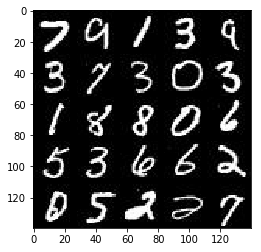

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

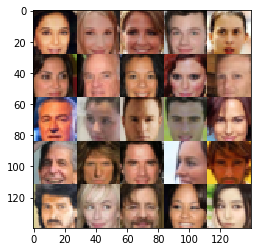

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # @ could add dropout between layers to prevent overfitting/memorization 
#         - slows down training time tho
    # @ use different depths/filters?
    # @ is batch normalization necessary in discriminator?
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        alpha = 0.2
        # images= 28 x 28 
        # first layer: conv2d (filters = 16,32,or64), no batch_norm, leaky relu
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same") # strides for downsampling
        x1 = tf.maximum(alpha*x1, x1)
        # 14 x 14 x 64
        
        # second layer: double depth with new layer, add batch_norm
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7 x 7 x 128
        
        # third layer: set padding 'valid' with no padding: ceil((7-5+1)/2) = 2 
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="valid")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 2 x 2 x 256
        
        # flatten:
        flat = tf.reshape(x3, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits) # prob. of how real the image is

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # @ relu vs leaky relu
    # @ add dropout around the 1st layer? (0.3 to 0.6)
    
    with tf.variable_scope("generator", reuse=not is_train):
        
        alpha = 0.2
        
        # fully-connected
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512)) # flat to 3D
        x1 = tf.layers.batch_normalization(x1, training=is_train) # stabilizes learning
        x1 = tf.maximum(alpha*x1, x1)
        # 7 x 7 x 512
        
        # transposed convolution 1 (inverse of convolution)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14 x 14 x 256
        
        # transposed convolution 2
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28 x 28 x 128
        
        # output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same")
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # update the generator and discriminator variables separately
    t_vars = tf.trainable_variables() # all variables defined in graph
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # build model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
#     losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images, lr:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    # save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0762 Generator Loss: 4.7408
Epoch 1/2... Discriminator Loss: 0.0134 Generator Loss: 11.2109
Epoch 1/2... Discriminator Loss: 0.3014 Generator Loss: 1.7033
Epoch 1/2... Discriminator Loss: 0.0112 Generator Loss: 5.4389
Epoch 1/2... Discriminator Loss: 0.0410 Generator Loss: 3.5921
Epoch 1/2... Discriminator Loss: 0.2015 Generator Loss: 2.1826
Epoch 1/2... Discriminator Loss: 0.0275 Generator Loss: 4.1338
Epoch 1/2... Discriminator Loss: 2.9920 Generator Loss: 0.5030
Epoch 1/2... Discriminator Loss: 0.9722 Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 0.6606 Generator Loss: 1.4289


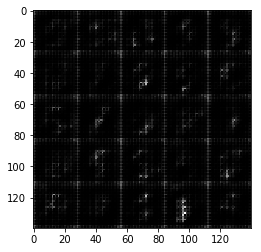

Epoch 1/2... Discriminator Loss: 0.5071 Generator Loss: 2.2712
Epoch 1/2... Discriminator Loss: 0.5091 Generator Loss: 1.5943
Epoch 1/2... Discriminator Loss: 0.4335 Generator Loss: 1.5336
Epoch 1/2... Discriminator Loss: 0.3522 Generator Loss: 1.9657
Epoch 1/2... Discriminator Loss: 0.3702 Generator Loss: 1.4977
Epoch 1/2... Discriminator Loss: 0.2806 Generator Loss: 1.8860
Epoch 1/2... Discriminator Loss: 0.0896 Generator Loss: 3.0858
Epoch 1/2... Discriminator Loss: 0.7592 Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 0.3148 Generator Loss: 1.7228
Epoch 1/2... Discriminator Loss: 0.1196 Generator Loss: 2.8742


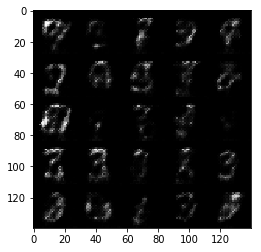

Epoch 1/2... Discriminator Loss: 0.0923 Generator Loss: 3.6108
Epoch 1/2... Discriminator Loss: 0.0790 Generator Loss: 3.6058
Epoch 1/2... Discriminator Loss: 0.0586 Generator Loss: 3.4945
Epoch 1/2... Discriminator Loss: 0.0649 Generator Loss: 3.5258
Epoch 1/2... Discriminator Loss: 0.0141 Generator Loss: 5.4747
Epoch 1/2... Discriminator Loss: 0.1890 Generator Loss: 2.5909
Epoch 1/2... Discriminator Loss: 0.1331 Generator Loss: 2.6829
Epoch 1/2... Discriminator Loss: 2.1946 Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 0.2795 Generator Loss: 2.1141
Epoch 1/2... Discriminator Loss: 0.0143 Generator Loss: 5.1740


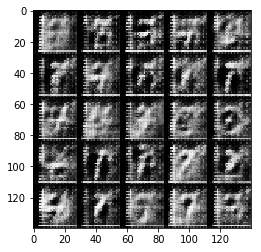

Epoch 1/2... Discriminator Loss: 0.0472 Generator Loss: 3.7479
Epoch 1/2... Discriminator Loss: 0.0519 Generator Loss: 3.8946
Epoch 1/2... Discriminator Loss: 0.2171 Generator Loss: 2.0594
Epoch 1/2... Discriminator Loss: 0.0315 Generator Loss: 3.9437
Epoch 1/2... Discriminator Loss: 0.1552 Generator Loss: 2.3580
Epoch 1/2... Discriminator Loss: 0.0709 Generator Loss: 4.0799
Epoch 1/2... Discriminator Loss: 0.1183 Generator Loss: 2.8726
Epoch 1/2... Discriminator Loss: 0.2793 Generator Loss: 2.0868
Epoch 1/2... Discriminator Loss: 0.2655 Generator Loss: 1.9758
Epoch 1/2... Discriminator Loss: 0.1205 Generator Loss: 3.0552


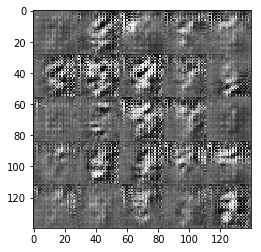

Epoch 1/2... Discriminator Loss: 0.0892 Generator Loss: 3.4578
Epoch 1/2... Discriminator Loss: 0.1874 Generator Loss: 3.8648
Epoch 1/2... Discriminator Loss: 0.1621 Generator Loss: 2.4480
Epoch 1/2... Discriminator Loss: 0.2489 Generator Loss: 2.0696
Epoch 1/2... Discriminator Loss: 0.1578 Generator Loss: 2.4769
Epoch 1/2... Discriminator Loss: 0.0300 Generator Loss: 5.8055
Epoch 1/2... Discriminator Loss: 0.1803 Generator Loss: 2.2165
Epoch 1/2... Discriminator Loss: 0.3321 Generator Loss: 1.5889
Epoch 1/2... Discriminator Loss: 0.2332 Generator Loss: 2.1675
Epoch 1/2... Discriminator Loss: 0.2557 Generator Loss: 2.0132


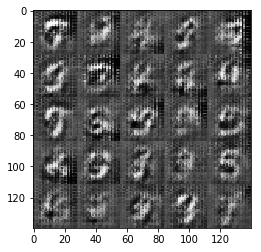

Epoch 1/2... Discriminator Loss: 0.2368 Generator Loss: 2.5571
Epoch 1/2... Discriminator Loss: 0.1491 Generator Loss: 2.6619
Epoch 1/2... Discriminator Loss: 0.0456 Generator Loss: 6.7674
Epoch 1/2... Discriminator Loss: 0.0628 Generator Loss: 3.7263
Epoch 1/2... Discriminator Loss: 0.0690 Generator Loss: 5.7990
Epoch 1/2... Discriminator Loss: 0.0565 Generator Loss: 4.2287
Epoch 1/2... Discriminator Loss: 0.0251 Generator Loss: 4.5998
Epoch 1/2... Discriminator Loss: 0.0417 Generator Loss: 4.1875
Epoch 1/2... Discriminator Loss: 0.0439 Generator Loss: 3.9877
Epoch 1/2... Discriminator Loss: 0.1931 Generator Loss: 2.3878


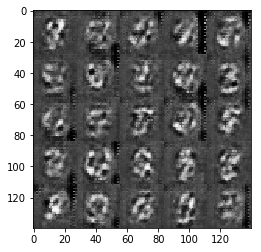

Epoch 1/2... Discriminator Loss: 1.8620 Generator Loss: 0.3394
Epoch 1/2... Discriminator Loss: 0.9521 Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 0.1648 Generator Loss: 3.1793
Epoch 1/2... Discriminator Loss: 1.1638 Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 0.0515 Generator Loss: 8.4691
Epoch 1/2... Discriminator Loss: 0.2773 Generator Loss: 1.7953
Epoch 1/2... Discriminator Loss: 0.0404 Generator Loss: 4.6438
Epoch 1/2... Discriminator Loss: 0.1307 Generator Loss: 3.1882
Epoch 1/2... Discriminator Loss: 0.0780 Generator Loss: 3.8036
Epoch 1/2... Discriminator Loss: 0.7117 Generator Loss: 0.9912


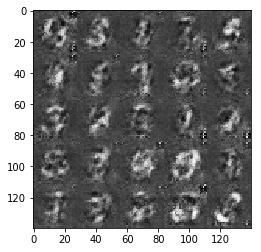

Epoch 1/2... Discriminator Loss: 0.2298 Generator Loss: 2.2494
Epoch 1/2... Discriminator Loss: 0.0685 Generator Loss: 4.1361
Epoch 1/2... Discriminator Loss: 0.0328 Generator Loss: 5.2582
Epoch 1/2... Discriminator Loss: 0.1833 Generator Loss: 2.2705
Epoch 1/2... Discriminator Loss: 0.0599 Generator Loss: 4.7541
Epoch 1/2... Discriminator Loss: 2.0687 Generator Loss: 0.1947
Epoch 1/2... Discriminator Loss: 1.0127 Generator Loss: 0.5983
Epoch 1/2... Discriminator Loss: 0.3203 Generator Loss: 2.1751
Epoch 1/2... Discriminator Loss: 0.1820 Generator Loss: 2.7342
Epoch 1/2... Discriminator Loss: 0.0649 Generator Loss: 6.3674


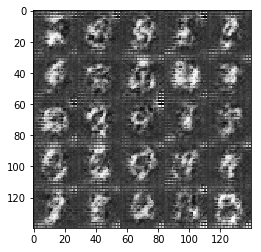

Epoch 1/2... Discriminator Loss: 0.3325 Generator Loss: 1.9807
Epoch 1/2... Discriminator Loss: 0.1281 Generator Loss: 2.6235
Epoch 1/2... Discriminator Loss: 0.8015 Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 0.0854 Generator Loss: 3.2777
Epoch 1/2... Discriminator Loss: 0.0908 Generator Loss: 3.0083
Epoch 1/2... Discriminator Loss: 0.0675 Generator Loss: 3.7757
Epoch 1/2... Discriminator Loss: 0.0730 Generator Loss: 3.4014
Epoch 1/2... Discriminator Loss: 0.0355 Generator Loss: 4.7345
Epoch 1/2... Discriminator Loss: 0.1042 Generator Loss: 3.6794
Epoch 1/2... Discriminator Loss: 0.3016 Generator Loss: 1.7063


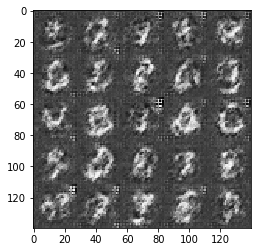

Epoch 1/2... Discriminator Loss: 0.1491 Generator Loss: 2.7319
Epoch 1/2... Discriminator Loss: 0.1114 Generator Loss: 2.8575
Epoch 1/2... Discriminator Loss: 0.2794 Generator Loss: 1.8543
Epoch 1/2... Discriminator Loss: 0.0205 Generator Loss: 6.3244
Epoch 1/2... Discriminator Loss: 0.0557 Generator Loss: 4.1073
Epoch 1/2... Discriminator Loss: 0.0414 Generator Loss: 4.7923
Epoch 1/2... Discriminator Loss: 0.0528 Generator Loss: 5.1461
Epoch 1/2... Discriminator Loss: 0.0457 Generator Loss: 4.0418
Epoch 1/2... Discriminator Loss: 0.0925 Generator Loss: 4.0972
Epoch 1/2... Discriminator Loss: 0.0514 Generator Loss: 4.5242


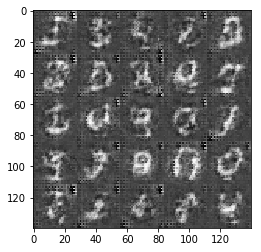

Epoch 1/2... Discriminator Loss: 0.0505 Generator Loss: 3.8627
Epoch 1/2... Discriminator Loss: 0.0975 Generator Loss: 3.2262
Epoch 1/2... Discriminator Loss: 3.5339 Generator Loss: 4.1303
Epoch 1/2... Discriminator Loss: 0.7717 Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 2.0375 Generator Loss: 0.2239
Epoch 1/2... Discriminator Loss: 0.5983 Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 0.4789 Generator Loss: 1.4979
Epoch 1/2... Discriminator Loss: 0.7103 Generator Loss: 1.1756
Epoch 1/2... Discriminator Loss: 1.1115 Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 0.3091 Generator Loss: 2.2306


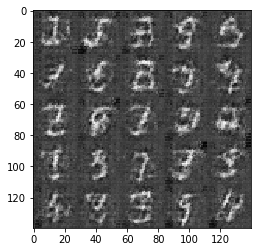

Epoch 1/2... Discriminator Loss: 0.4248 Generator Loss: 4.1024
Epoch 1/2... Discriminator Loss: 0.1272 Generator Loss: 3.2793
Epoch 1/2... Discriminator Loss: 0.4443 Generator Loss: 1.3278
Epoch 1/2... Discriminator Loss: 0.2416 Generator Loss: 2.3118
Epoch 1/2... Discriminator Loss: 0.1592 Generator Loss: 2.4783
Epoch 1/2... Discriminator Loss: 0.0686 Generator Loss: 3.9299
Epoch 1/2... Discriminator Loss: 1.2524 Generator Loss: 2.9782
Epoch 1/2... Discriminator Loss: 0.7014 Generator Loss: 1.5358
Epoch 1/2... Discriminator Loss: 0.4078 Generator Loss: 1.7461
Epoch 1/2... Discriminator Loss: 0.2411 Generator Loss: 3.6065


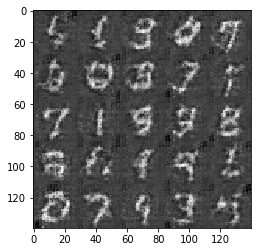

Epoch 1/2... Discriminator Loss: 0.3741 Generator Loss: 1.5363
Epoch 1/2... Discriminator Loss: 0.3222 Generator Loss: 1.5389
Epoch 1/2... Discriminator Loss: 0.9668 Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 0.8531 Generator Loss: 1.4352
Epoch 1/2... Discriminator Loss: 0.7749 Generator Loss: 1.0733
Epoch 1/2... Discriminator Loss: 0.6853 Generator Loss: 1.4508
Epoch 1/2... Discriminator Loss: 0.6440 Generator Loss: 1.3205
Epoch 1/2... Discriminator Loss: 0.7345 Generator Loss: 1.2804
Epoch 1/2... Discriminator Loss: 1.4353 Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 0.5526 Generator Loss: 1.5717


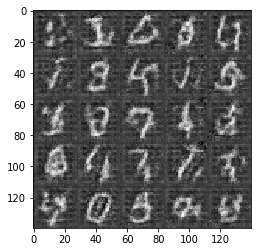

Epoch 1/2... Discriminator Loss: 0.6921 Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 0.6730 Generator Loss: 1.1436
Epoch 1/2... Discriminator Loss: 0.5008 Generator Loss: 1.6027
Epoch 1/2... Discriminator Loss: 0.4185 Generator Loss: 1.7158
Epoch 1/2... Discriminator Loss: 0.4199 Generator Loss: 1.5992
Epoch 1/2... Discriminator Loss: 0.2821 Generator Loss: 1.9004
Epoch 1/2... Discriminator Loss: 0.0992 Generator Loss: 4.3091
Epoch 1/2... Discriminator Loss: 0.0366 Generator Loss: 4.8533
Epoch 1/2... Discriminator Loss: 0.6858 Generator Loss: 0.9830
Epoch 1/2... Discriminator Loss: 0.0739 Generator Loss: 3.8113


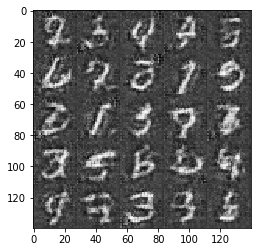

Epoch 1/2... Discriminator Loss: 0.1922 Generator Loss: 3.3073
Epoch 1/2... Discriminator Loss: 0.1039 Generator Loss: 3.2266
Epoch 1/2... Discriminator Loss: 0.0430 Generator Loss: 4.6515
Epoch 1/2... Discriminator Loss: 0.0329 Generator Loss: 4.1971
Epoch 1/2... Discriminator Loss: 0.1340 Generator Loss: 2.3915
Epoch 1/2... Discriminator Loss: 0.0345 Generator Loss: 4.2356
Epoch 1/2... Discriminator Loss: 0.0428 Generator Loss: 4.8288
Epoch 1/2... Discriminator Loss: 0.0185 Generator Loss: 6.8174
Epoch 1/2... Discriminator Loss: 1.0262 Generator Loss: 0.9542
Epoch 1/2... Discriminator Loss: 0.8999 Generator Loss: 1.0770


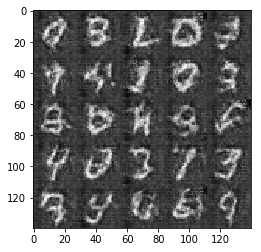

Epoch 1/2... Discriminator Loss: 0.8015 Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 0.9991 Generator Loss: 0.8525
Epoch 1/2... Discriminator Loss: 0.7504 Generator Loss: 1.3062
Epoch 1/2... Discriminator Loss: 0.8781 Generator Loss: 0.9322
Epoch 1/2... Discriminator Loss: 0.9646 Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 0.6396 Generator Loss: 1.3149
Epoch 1/2... Discriminator Loss: 0.6374 Generator Loss: 1.8944
Epoch 1/2... Discriminator Loss: 0.7503 Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 0.6442 Generator Loss: 1.7619
Epoch 1/2... Discriminator Loss: 0.7106 Generator Loss: 0.9828


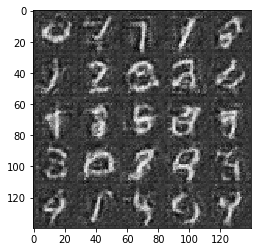

Epoch 1/2... Discriminator Loss: 0.7063 Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 0.4821 Generator Loss: 1.2570
Epoch 1/2... Discriminator Loss: 0.4120 Generator Loss: 1.7143
Epoch 1/2... Discriminator Loss: 0.2506 Generator Loss: 2.5277
Epoch 1/2... Discriminator Loss: 0.9929 Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 0.2388 Generator Loss: 1.9644
Epoch 1/2... Discriminator Loss: 0.0700 Generator Loss: 3.1752
Epoch 1/2... Discriminator Loss: 0.3160 Generator Loss: 1.6251
Epoch 1/2... Discriminator Loss: 0.0393 Generator Loss: 5.6123
Epoch 1/2... Discriminator Loss: 0.1859 Generator Loss: 2.3426


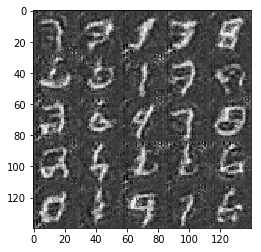

Epoch 1/2... Discriminator Loss: 0.0215 Generator Loss: 6.9084
Epoch 1/2... Discriminator Loss: 0.0174 Generator Loss: 6.2390
Epoch 1/2... Discriminator Loss: 0.0119 Generator Loss: 6.4622
Epoch 1/2... Discriminator Loss: 0.0179 Generator Loss: 5.2751
Epoch 1/2... Discriminator Loss: 0.0311 Generator Loss: 6.5824
Epoch 1/2... Discriminator Loss: 0.0896 Generator Loss: 4.1333
Epoch 1/2... Discriminator Loss: 0.0192 Generator Loss: 5.5495
Epoch 1/2... Discriminator Loss: 0.0234 Generator Loss: 5.3569
Epoch 1/2... Discriminator Loss: 0.0197 Generator Loss: 6.5601
Epoch 1/2... Discriminator Loss: 0.0283 Generator Loss: 4.6422


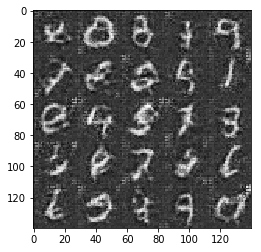

Epoch 1/2... Discriminator Loss: 0.1595 Generator Loss: 2.6139
Epoch 1/2... Discriminator Loss: 0.0336 Generator Loss: 4.4666
Epoch 1/2... Discriminator Loss: 0.0261 Generator Loss: 4.4779
Epoch 1/2... Discriminator Loss: 0.0929 Generator Loss: 4.0570
Epoch 1/2... Discriminator Loss: 0.0159 Generator Loss: 6.6683
Epoch 1/2... Discriminator Loss: 0.0614 Generator Loss: 3.5132
Epoch 1/2... Discriminator Loss: 0.1538 Generator Loss: 2.6663
Epoch 2/2... Discriminator Loss: 0.0207 Generator Loss: 5.5455
Epoch 2/2... Discriminator Loss: 0.5945 Generator Loss: 1.0713
Epoch 2/2... Discriminator Loss: 0.0536 Generator Loss: 6.5028


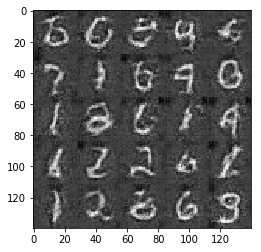

Epoch 2/2... Discriminator Loss: 0.0981 Generator Loss: 2.9848
Epoch 2/2... Discriminator Loss: 0.1846 Generator Loss: 2.3006
Epoch 2/2... Discriminator Loss: 0.2313 Generator Loss: 6.1474
Epoch 2/2... Discriminator Loss: 0.8700 Generator Loss: 0.8074
Epoch 2/2... Discriminator Loss: 0.6813 Generator Loss: 1.6816
Epoch 2/2... Discriminator Loss: 0.5670 Generator Loss: 1.1437
Epoch 2/2... Discriminator Loss: 0.7168 Generator Loss: 0.9108
Epoch 2/2... Discriminator Loss: 0.1906 Generator Loss: 2.3945
Epoch 2/2... Discriminator Loss: 0.1546 Generator Loss: 4.6232
Epoch 2/2... Discriminator Loss: 0.3278 Generator Loss: 2.4420


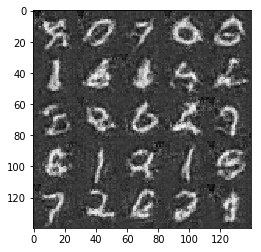

Epoch 2/2... Discriminator Loss: 0.5020 Generator Loss: 1.5280
Epoch 2/2... Discriminator Loss: 0.0305 Generator Loss: 5.2444
Epoch 2/2... Discriminator Loss: 0.0577 Generator Loss: 3.2654
Epoch 2/2... Discriminator Loss: 0.0265 Generator Loss: 5.0503
Epoch 2/2... Discriminator Loss: 0.1542 Generator Loss: 2.4738
Epoch 2/2... Discriminator Loss: 1.2797 Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 0.7011 Generator Loss: 1.6167
Epoch 2/2... Discriminator Loss: 0.8996 Generator Loss: 0.7724
Epoch 2/2... Discriminator Loss: 0.5868 Generator Loss: 1.2888
Epoch 2/2... Discriminator Loss: 0.6741 Generator Loss: 1.3681


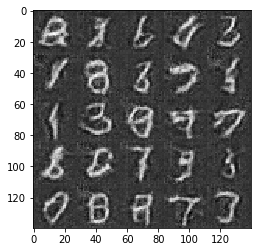

Epoch 2/2... Discriminator Loss: 0.7119 Generator Loss: 2.0039
Epoch 2/2... Discriminator Loss: 0.7756 Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 0.7145 Generator Loss: 1.2796
Epoch 2/2... Discriminator Loss: 0.9431 Generator Loss: 0.6404
Epoch 2/2... Discriminator Loss: 0.5248 Generator Loss: 2.0370
Epoch 2/2... Discriminator Loss: 0.4939 Generator Loss: 1.3503
Epoch 2/2... Discriminator Loss: 0.8774 Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 0.2394 Generator Loss: 2.1861
Epoch 2/2... Discriminator Loss: 0.6850 Generator Loss: 1.0427
Epoch 2/2... Discriminator Loss: 1.1674 Generator Loss: 4.1652


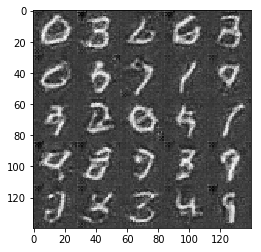

Epoch 2/2... Discriminator Loss: 0.7504 Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 0.0515 Generator Loss: 5.2211
Epoch 2/2... Discriminator Loss: 0.5123 Generator Loss: 1.1881
Epoch 2/2... Discriminator Loss: 1.4478 Generator Loss: 0.4023
Epoch 2/2... Discriminator Loss: 0.2067 Generator Loss: 2.5314
Epoch 2/2... Discriminator Loss: 0.2958 Generator Loss: 2.4471
Epoch 2/2... Discriminator Loss: 0.0678 Generator Loss: 3.5617
Epoch 2/2... Discriminator Loss: 0.2131 Generator Loss: 2.5071
Epoch 2/2... Discriminator Loss: 0.0227 Generator Loss: 5.4232
Epoch 2/2... Discriminator Loss: 0.2019 Generator Loss: 2.4981


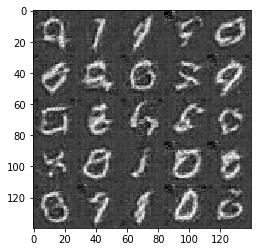

Epoch 2/2... Discriminator Loss: 0.0301 Generator Loss: 5.6026
Epoch 2/2... Discriminator Loss: 1.7942 Generator Loss: 0.3252
Epoch 2/2... Discriminator Loss: 0.5463 Generator Loss: 1.2038
Epoch 2/2... Discriminator Loss: 0.4841 Generator Loss: 1.4973
Epoch 2/2... Discriminator Loss: 0.2377 Generator Loss: 2.1654
Epoch 2/2... Discriminator Loss: 0.0833 Generator Loss: 4.5414
Epoch 2/2... Discriminator Loss: 0.0647 Generator Loss: 3.6808
Epoch 2/2... Discriminator Loss: 0.1543 Generator Loss: 2.4539
Epoch 2/2... Discriminator Loss: 0.0441 Generator Loss: 4.4383
Epoch 2/2... Discriminator Loss: 0.0550 Generator Loss: 6.6668


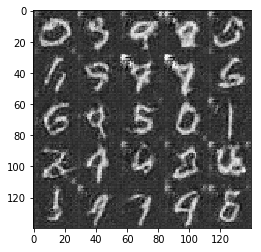

Epoch 2/2... Discriminator Loss: 0.1275 Generator Loss: 2.8562
Epoch 2/2... Discriminator Loss: 0.0109 Generator Loss: 6.5177
Epoch 2/2... Discriminator Loss: 0.2630 Generator Loss: 1.9788
Epoch 2/2... Discriminator Loss: 0.0259 Generator Loss: 5.3689
Epoch 2/2... Discriminator Loss: 0.0587 Generator Loss: 4.3389
Epoch 2/2... Discriminator Loss: 0.0396 Generator Loss: 4.7895
Epoch 2/2... Discriminator Loss: 0.0938 Generator Loss: 3.3519
Epoch 2/2... Discriminator Loss: 0.0393 Generator Loss: 4.8259
Epoch 2/2... Discriminator Loss: 0.1383 Generator Loss: 3.0063
Epoch 2/2... Discriminator Loss: 0.0285 Generator Loss: 5.9389


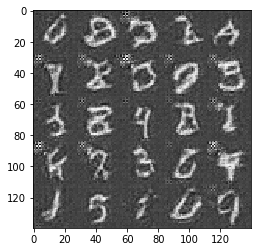

Epoch 2/2... Discriminator Loss: 0.0154 Generator Loss: 6.7664
Epoch 2/2... Discriminator Loss: 0.0123 Generator Loss: 7.1471
Epoch 2/2... Discriminator Loss: 0.0803 Generator Loss: 3.2635
Epoch 2/2... Discriminator Loss: 0.0117 Generator Loss: 5.5324
Epoch 2/2... Discriminator Loss: 0.5186 Generator Loss: 1.4591
Epoch 2/2... Discriminator Loss: 0.0328 Generator Loss: 4.6024
Epoch 2/2... Discriminator Loss: 0.1195 Generator Loss: 7.6304
Epoch 2/2... Discriminator Loss: 0.9830 Generator Loss: 2.6935
Epoch 2/2... Discriminator Loss: 0.7080 Generator Loss: 1.3443
Epoch 2/2... Discriminator Loss: 0.5603 Generator Loss: 1.7211


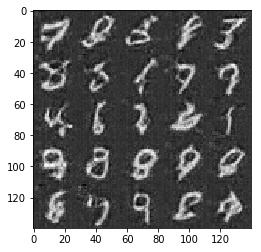

Epoch 2/2... Discriminator Loss: 0.7764 Generator Loss: 2.4579
Epoch 2/2... Discriminator Loss: 0.5727 Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 0.6258 Generator Loss: 1.9559
Epoch 2/2... Discriminator Loss: 0.3334 Generator Loss: 2.3275
Epoch 2/2... Discriminator Loss: 1.2411 Generator Loss: 4.2187
Epoch 2/2... Discriminator Loss: 0.3585 Generator Loss: 2.2115
Epoch 2/2... Discriminator Loss: 1.0793 Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 0.8897 Generator Loss: 4.7530
Epoch 2/2... Discriminator Loss: 0.4033 Generator Loss: 2.2073
Epoch 2/2... Discriminator Loss: 0.1982 Generator Loss: 3.0192


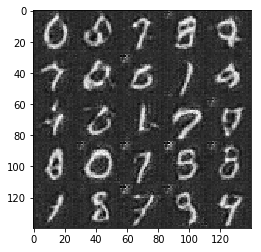

Epoch 2/2... Discriminator Loss: 0.1663 Generator Loss: 3.5575
Epoch 2/2... Discriminator Loss: 0.3966 Generator Loss: 1.7250
Epoch 2/2... Discriminator Loss: 0.0897 Generator Loss: 3.8421
Epoch 2/2... Discriminator Loss: 0.0845 Generator Loss: 4.7804
Epoch 2/2... Discriminator Loss: 0.1409 Generator Loss: 2.7972
Epoch 2/2... Discriminator Loss: 0.1346 Generator Loss: 2.9823
Epoch 2/2... Discriminator Loss: 0.0804 Generator Loss: 3.6725
Epoch 2/2... Discriminator Loss: 0.0160 Generator Loss: 6.7108
Epoch 2/2... Discriminator Loss: 0.0399 Generator Loss: 4.7578
Epoch 2/2... Discriminator Loss: 0.0781 Generator Loss: 3.9082


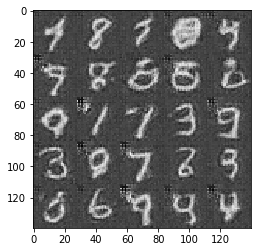

Epoch 2/2... Discriminator Loss: 0.0710 Generator Loss: 3.4803
Epoch 2/2... Discriminator Loss: 0.1089 Generator Loss: 3.1509
Epoch 2/2... Discriminator Loss: 0.2886 Generator Loss: 1.9054
Epoch 2/2... Discriminator Loss: 0.0430 Generator Loss: 4.5989
Epoch 2/2... Discriminator Loss: 0.0371 Generator Loss: 4.1698
Epoch 2/2... Discriminator Loss: 0.0175 Generator Loss: 5.3477
Epoch 2/2... Discriminator Loss: 0.0285 Generator Loss: 5.4174
Epoch 2/2... Discriminator Loss: 0.1987 Generator Loss: 2.7641
Epoch 2/2... Discriminator Loss: 0.0505 Generator Loss: 3.5522
Epoch 2/2... Discriminator Loss: 0.0301 Generator Loss: 5.9526


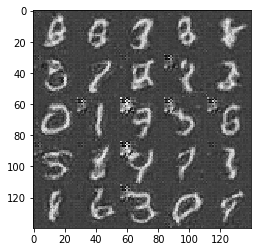

Epoch 2/2... Discriminator Loss: 0.0400 Generator Loss: 5.5457
Epoch 2/2... Discriminator Loss: 0.3483 Generator Loss: 2.0475
Epoch 2/2... Discriminator Loss: 0.0238 Generator Loss: 5.0635
Epoch 2/2... Discriminator Loss: 0.3909 Generator Loss: 2.5607
Epoch 2/2... Discriminator Loss: 0.5025 Generator Loss: 1.1607
Epoch 2/2... Discriminator Loss: 1.0252 Generator Loss: 0.6185
Epoch 2/2... Discriminator Loss: 1.2004 Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 0.2722 Generator Loss: 2.2776
Epoch 2/2... Discriminator Loss: 0.0915 Generator Loss: 3.2807
Epoch 2/2... Discriminator Loss: 0.0895 Generator Loss: 3.6274


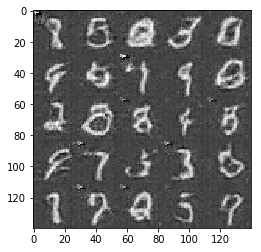

Epoch 2/2... Discriminator Loss: 0.0720 Generator Loss: 4.1553
Epoch 2/2... Discriminator Loss: 0.0691 Generator Loss: 4.2397
Epoch 2/2... Discriminator Loss: 0.4738 Generator Loss: 1.4303
Epoch 2/2... Discriminator Loss: 0.0383 Generator Loss: 5.1406
Epoch 2/2... Discriminator Loss: 0.0777 Generator Loss: 6.1825
Epoch 2/2... Discriminator Loss: 0.0688 Generator Loss: 3.5835
Epoch 2/2... Discriminator Loss: 0.0519 Generator Loss: 4.7478
Epoch 2/2... Discriminator Loss: 0.0990 Generator Loss: 3.6718
Epoch 2/2... Discriminator Loss: 0.0233 Generator Loss: 5.0976
Epoch 2/2... Discriminator Loss: 0.0909 Generator Loss: 3.6322


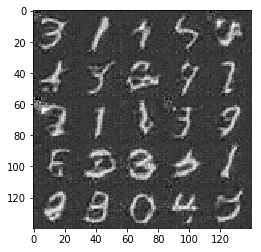

Epoch 2/2... Discriminator Loss: 0.0177 Generator Loss: 7.5060
Epoch 2/2... Discriminator Loss: 0.0710 Generator Loss: 4.0169
Epoch 2/2... Discriminator Loss: 0.0256 Generator Loss: 5.0339
Epoch 2/2... Discriminator Loss: 0.0188 Generator Loss: 5.7139
Epoch 2/2... Discriminator Loss: 0.0196 Generator Loss: 5.4849
Epoch 2/2... Discriminator Loss: 0.0286 Generator Loss: 5.0897
Epoch 2/2... Discriminator Loss: 0.9537 Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 0.4403 Generator Loss: 1.6333
Epoch 2/2... Discriminator Loss: 0.3936 Generator Loss: 2.2570
Epoch 2/2... Discriminator Loss: 0.1022 Generator Loss: 3.9400


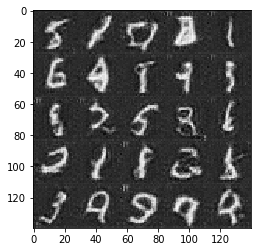

Epoch 2/2... Discriminator Loss: 1.1425 Generator Loss: 0.8368
Epoch 2/2... Discriminator Loss: 0.8592 Generator Loss: 0.8999
Epoch 2/2... Discriminator Loss: 0.6861 Generator Loss: 1.3844
Epoch 2/2... Discriminator Loss: 0.9258 Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 0.5471 Generator Loss: 1.3969
Epoch 2/2... Discriminator Loss: 0.5293 Generator Loss: 1.6349
Epoch 2/2... Discriminator Loss: 0.6938 Generator Loss: 2.2507
Epoch 2/2... Discriminator Loss: 0.6493 Generator Loss: 1.1767
Epoch 2/2... Discriminator Loss: 0.3228 Generator Loss: 1.9169
Epoch 2/2... Discriminator Loss: 0.1408 Generator Loss: 3.8764


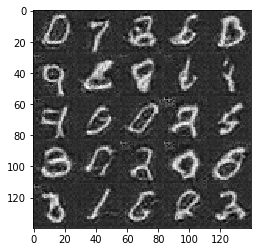

Epoch 2/2... Discriminator Loss: 0.9721 Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 0.6410 Generator Loss: 2.4459
Epoch 2/2... Discriminator Loss: 0.5808 Generator Loss: 1.4174
Epoch 2/2... Discriminator Loss: 0.6968 Generator Loss: 1.1053
Epoch 2/2... Discriminator Loss: 0.3306 Generator Loss: 1.9826
Epoch 2/2... Discriminator Loss: 0.2258 Generator Loss: 2.5802
Epoch 2/2... Discriminator Loss: 0.0761 Generator Loss: 3.8481
Epoch 2/2... Discriminator Loss: 0.3264 Generator Loss: 2.6290
Epoch 2/2... Discriminator Loss: 0.0481 Generator Loss: 3.9408
Epoch 2/2... Discriminator Loss: 0.3438 Generator Loss: 1.6147


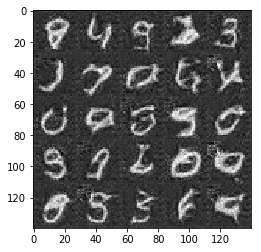

Epoch 2/2... Discriminator Loss: 0.0341 Generator Loss: 5.7850
Epoch 2/2... Discriminator Loss: 0.1004 Generator Loss: 3.1230
Epoch 2/2... Discriminator Loss: 0.1688 Generator Loss: 2.6905
Epoch 2/2... Discriminator Loss: 0.0482 Generator Loss: 4.8447
Epoch 2/2... Discriminator Loss: 0.0319 Generator Loss: 5.0837
Epoch 2/2... Discriminator Loss: 0.0622 Generator Loss: 5.5007
Epoch 2/2... Discriminator Loss: 0.0439 Generator Loss: 3.9146
Epoch 2/2... Discriminator Loss: 0.0373 Generator Loss: 4.1407
Epoch 2/2... Discriminator Loss: 0.2516 Generator Loss: 2.3374
Epoch 2/2... Discriminator Loss: 0.1012 Generator Loss: 2.9888


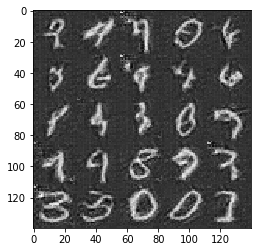

Epoch 2/2... Discriminator Loss: 0.3086 Generator Loss: 1.5623
Epoch 2/2... Discriminator Loss: 2.5371 Generator Loss: 0.2971
Epoch 2/2... Discriminator Loss: 1.0878 Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 0.5092 Generator Loss: 2.2451
Epoch 2/2... Discriminator Loss: 0.1911 Generator Loss: 3.3039
Epoch 2/2... Discriminator Loss: 0.5669 Generator Loss: 1.2421
Epoch 2/2... Discriminator Loss: 0.2026 Generator Loss: 3.3634
Epoch 2/2... Discriminator Loss: 0.0317 Generator Loss: 5.8508
Epoch 2/2... Discriminator Loss: 0.0593 Generator Loss: 4.1361
Epoch 2/2... Discriminator Loss: 0.0156 Generator Loss: 5.2840


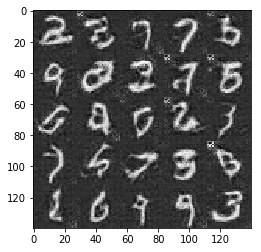

Epoch 2/2... Discriminator Loss: 0.1886 Generator Loss: 2.6746
Epoch 2/2... Discriminator Loss: 0.4432 Generator Loss: 1.9670
Epoch 2/2... Discriminator Loss: 0.6668 Generator Loss: 1.6717
Epoch 2/2... Discriminator Loss: 0.7813 Generator Loss: 0.8197
Epoch 2/2... Discriminator Loss: 0.7239 Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 0.4470 Generator Loss: 1.7554
Epoch 2/2... Discriminator Loss: 0.2079 Generator Loss: 4.4727
Epoch 2/2... Discriminator Loss: 0.2400 Generator Loss: 2.1196
Epoch 2/2... Discriminator Loss: 0.0841 Generator Loss: 6.7754
Epoch 2/2... Discriminator Loss: 0.5189 Generator Loss: 1.7838


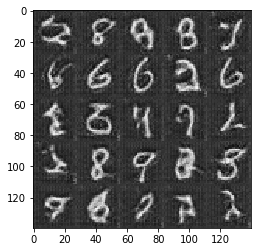

Epoch 2/2... Discriminator Loss: 0.4955 Generator Loss: 1.7098
Epoch 2/2... Discriminator Loss: 0.4063 Generator Loss: 1.8069
Epoch 2/2... Discriminator Loss: 0.6200 Generator Loss: 1.1039
Epoch 2/2... Discriminator Loss: 0.8550 Generator Loss: 0.9687
Epoch 2/2... Discriminator Loss: 0.0636 Generator Loss: 4.9881


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1398 Generator Loss: 4.0207
Epoch 1/1... Discriminator Loss: 3.2993 Generator Loss: 0.2627
Epoch 1/1... Discriminator Loss: 3.3612 Generator Loss: 6.1058
Epoch 1/1... Discriminator Loss: 1.2946 Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 1.2413 Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 0.3169 Generator Loss: 1.9721
Epoch 1/1... Discriminator Loss: 0.8211 Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 0.2902 Generator Loss: 2.2456
Epoch 1/1... Discriminator Loss: 0.0469 Generator Loss: 3.7561
Epoch 1/1... Discriminator Loss: 0.0720 Generator Loss: 3.4029


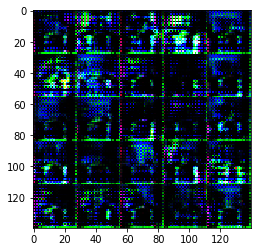

Epoch 1/1... Discriminator Loss: 0.0068 Generator Loss: 6.0011
Epoch 1/1... Discriminator Loss: 0.0180 Generator Loss: 4.3348
Epoch 1/1... Discriminator Loss: 0.0111 Generator Loss: 5.7786
Epoch 1/1... Discriminator Loss: 0.0084 Generator Loss: 5.4240
Epoch 1/1... Discriminator Loss: 0.0472 Generator Loss: 3.5077
Epoch 1/1... Discriminator Loss: 0.0068 Generator Loss: 9.6590
Epoch 1/1... Discriminator Loss: 3.0469 Generator Loss: 6.9260
Epoch 1/1... Discriminator Loss: 0.5821 Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 0.2238 Generator Loss: 1.9062
Epoch 1/1... Discriminator Loss: 0.1447 Generator Loss: 2.6587


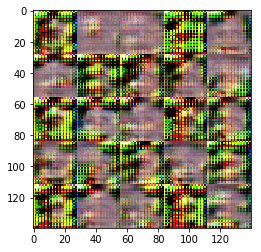

Epoch 1/1... Discriminator Loss: 3.1363 Generator Loss: 6.8479
Epoch 1/1... Discriminator Loss: 0.3801 Generator Loss: 2.0478
Epoch 1/1... Discriminator Loss: 0.0344 Generator Loss: 4.5125
Epoch 1/1... Discriminator Loss: 0.1232 Generator Loss: 2.4515
Epoch 1/1... Discriminator Loss: 0.1225 Generator Loss: 2.8786
Epoch 1/1... Discriminator Loss: 0.0141 Generator Loss: 4.9208
Epoch 1/1... Discriminator Loss: 0.0256 Generator Loss: 4.7942
Epoch 1/1... Discriminator Loss: 0.0092 Generator Loss: 6.6410
Epoch 1/1... Discriminator Loss: 1.3698 Generator Loss: 2.7802
Epoch 1/1... Discriminator Loss: 0.1258 Generator Loss: 2.6128


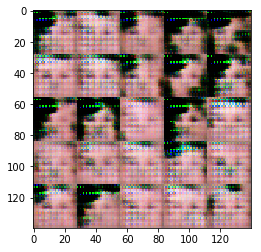

Epoch 1/1... Discriminator Loss: 0.0380 Generator Loss: 6.3087
Epoch 1/1... Discriminator Loss: 0.0522 Generator Loss: 3.7610
Epoch 1/1... Discriminator Loss: 1.0895 Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.9494 Generator Loss: 0.2481
Epoch 1/1... Discriminator Loss: 0.2930 Generator Loss: 2.3445
Epoch 1/1... Discriminator Loss: 0.4399 Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 0.2948 Generator Loss: 2.3055
Epoch 1/1... Discriminator Loss: 0.0955 Generator Loss: 3.1558
Epoch 1/1... Discriminator Loss: 0.0969 Generator Loss: 3.9483
Epoch 1/1... Discriminator Loss: 0.0439 Generator Loss: 4.6694


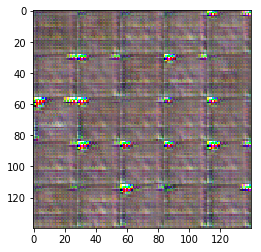

Epoch 1/1... Discriminator Loss: 0.0395 Generator Loss: 4.7705
Epoch 1/1... Discriminator Loss: 7.9899 Generator Loss: 0.0079
Epoch 1/1... Discriminator Loss: 1.0277 Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 0.5723 Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.1285 Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 0.2960 Generator Loss: 2.3525
Epoch 1/1... Discriminator Loss: 0.1487 Generator Loss: 3.7253
Epoch 1/1... Discriminator Loss: 0.0811 Generator Loss: 4.0269
Epoch 1/1... Discriminator Loss: 0.1448 Generator Loss: 2.8733
Epoch 1/1... Discriminator Loss: 0.3491 Generator Loss: 2.7562


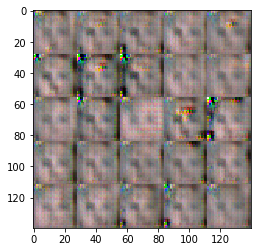

Epoch 1/1... Discriminator Loss: 0.1499 Generator Loss: 2.6327
Epoch 1/1... Discriminator Loss: 0.0863 Generator Loss: 3.3567
Epoch 1/1... Discriminator Loss: 0.0634 Generator Loss: 4.5296
Epoch 1/1... Discriminator Loss: 0.0509 Generator Loss: 3.9632
Epoch 1/1... Discriminator Loss: 0.0728 Generator Loss: 3.9513
Epoch 1/1... Discriminator Loss: 0.0606 Generator Loss: 3.8338
Epoch 1/1... Discriminator Loss: 0.1295 Generator Loss: 3.0011
Epoch 1/1... Discriminator Loss: 6.8300 Generator Loss: 0.0405
Epoch 1/1... Discriminator Loss: 2.0057 Generator Loss: 0.3267
Epoch 1/1... Discriminator Loss: 0.8883 Generator Loss: 1.6770


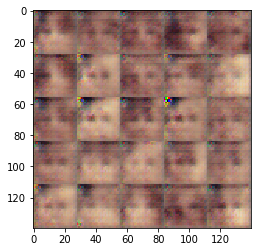

Epoch 1/1... Discriminator Loss: 0.7906 Generator Loss: 1.8729
Epoch 1/1... Discriminator Loss: 0.8517 Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.7514 Generator Loss: 3.2373
Epoch 1/1... Discriminator Loss: 0.5048 Generator Loss: 1.7973
Epoch 1/1... Discriminator Loss: 1.5177 Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 1.8672 Generator Loss: 0.2374
Epoch 1/1... Discriminator Loss: 0.7860 Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.3484 Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 2.0880 Generator Loss: 0.1984
Epoch 1/1... Discriminator Loss: 0.9567 Generator Loss: 0.8090


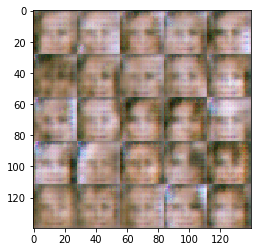

Epoch 1/1... Discriminator Loss: 1.4365 Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.1237 Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.0970 Generator Loss: 1.4452
Epoch 1/1... Discriminator Loss: 0.8711 Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 1.3550 Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.6245 Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.0214 Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.6239 Generator Loss: 0.4634
Epoch 1/1... Discriminator Loss: 1.0482 Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.8107 Generator Loss: 0.2903


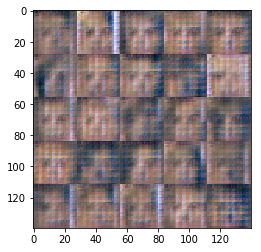

Epoch 1/1... Discriminator Loss: 1.7350 Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.0651 Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.0537 Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.0795 Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.2862 Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.0285 Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.7167 Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 0.6739 Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.2016 Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 1.3557 Generator Loss: 0.6277


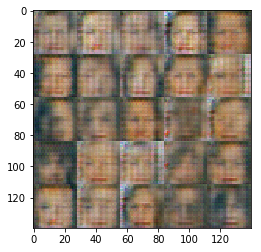

Epoch 1/1... Discriminator Loss: 1.0798 Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 0.9734 Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.8477 Generator Loss: 0.3209
Epoch 1/1... Discriminator Loss: 1.2537 Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3366 Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4746 Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.0645 Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.2756 Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.6317 Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 1.2380 Generator Loss: 0.7277


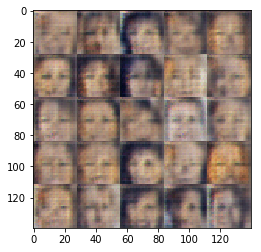

Epoch 1/1... Discriminator Loss: 1.4146 Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.5209 Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.4177 Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.2322 Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.2037 Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.0406 Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.5786 Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.1663 Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3854 Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3641 Generator Loss: 0.6302


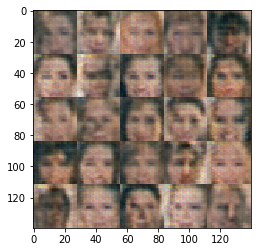

Epoch 1/1... Discriminator Loss: 1.6341 Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.2494 Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.0058 Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.6601 Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.3645 Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.7258 Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.1925 Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2734 Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4991 Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.5793 Generator Loss: 0.6423


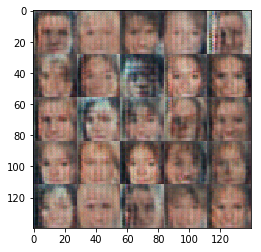

Epoch 1/1... Discriminator Loss: 1.4096 Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.2698 Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3323 Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3677 Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.0909 Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.1860 Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4580 Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.4082 Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.7570 Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.1087 Generator Loss: 0.8890


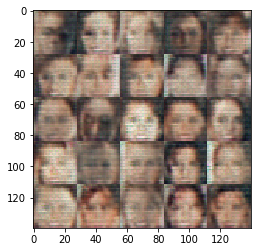

Epoch 1/1... Discriminator Loss: 1.3925 Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.0273 Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.2357 Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3372 Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.2753 Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.2886 Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.2605 Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.2033 Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.6412 Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.2551 Generator Loss: 0.6823


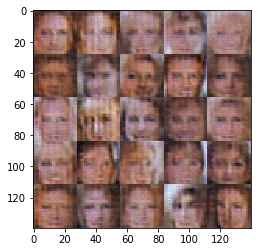

Epoch 1/1... Discriminator Loss: 1.1354 Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3404 Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.2477 Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.2279 Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.2042 Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.5158 Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.3647 Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.1102 Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.2488 Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.2598 Generator Loss: 0.6421


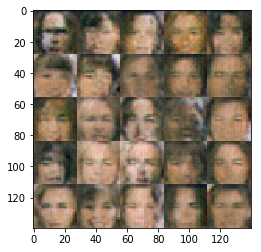

Epoch 1/1... Discriminator Loss: 1.3847 Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.3705 Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.3070 Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.1360 Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.2934 Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.4675 Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.3671 Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.3256 Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.6069 Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.2836 Generator Loss: 0.6389


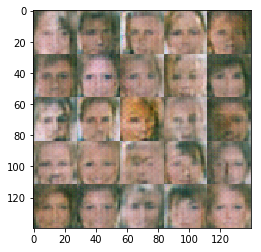

Epoch 1/1... Discriminator Loss: 1.1944 Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.3354 Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3034 Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.5885 Generator Loss: 0.4478
Epoch 1/1... Discriminator Loss: 1.3544 Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.0696 Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.4498 Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.1335 Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.2932 Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2595 Generator Loss: 0.6505


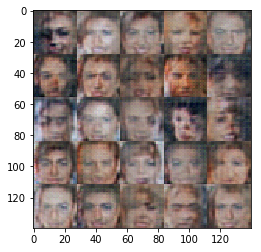

Epoch 1/1... Discriminator Loss: 1.4788 Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3732 Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.5148 Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 1.3116 Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.5199 Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.3180 Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.2178 Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.4167 Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.2146 Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.1105 Generator Loss: 0.8644


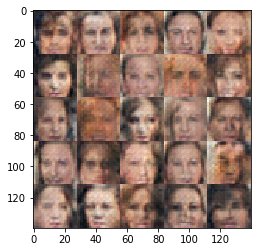

Epoch 1/1... Discriminator Loss: 1.4175 Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.3195 Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.1754 Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.2284 Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4024 Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.2763 Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4042 Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.1824 Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.1535 Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.2490 Generator Loss: 0.6110


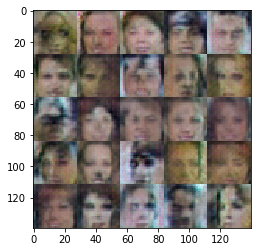

Epoch 1/1... Discriminator Loss: 1.2823 Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.1945 Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.2261 Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.5264 Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.4004 Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.3958 Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.0992 Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2618 Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.2885 Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.2547 Generator Loss: 0.7011


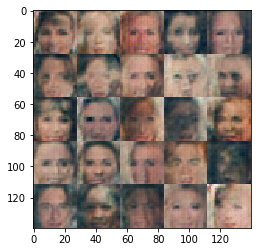

Epoch 1/1... Discriminator Loss: 1.4434 Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.1682 Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.2295 Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3725 Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4004 Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.3295 Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.1427 Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.2436 Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3845 Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.3078 Generator Loss: 0.6246


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.